# DIVAnd in sigma coordinates
## Import packages

In [1]:
using NCDatasets
using Makie, CairoMakie, GeoMakie
using DataStructures
using DIVAnd
using Dates
using Statistics
using Random
using Interpolations
using Roots
include("../config.jl")

"https://dox.uliege.be/index.php/s/h8d3pyqmuea6J9H/download"

## Configuration
* Define the horizontal, vertical (depth levels) and temporal resolutions.
* Select the variable of interest

In [2]:
dx, dy = 0.125, 0.125
lonr = 11.5:dx:20
latr = 39:dy:46

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
depthr = depthr[1:20];

## 1. Read your ODV file
Adapt the `datadir` and `datafile` values.     
The example is based on a sub-setting of the [Mediterranean Sea](https://www.seadatanet.org/Products#/metadata/cd552057-b604-4004-b838-a4f73cc98fcf) aggregated dataset.      
The dataset has been extracted around the Adriatic Sea and exported to a netCDF using [Ocean Data View](https://odv.awi.de/).
<img src="./Images/MedSeaAggreg.jpg" width="450px">

Download the data files (test and full) if needed.

In [3]:
datafile = adriaticfile
download_check(datafile, adriaticfileURL)

[ Info: File already downloaded


Read the full file:

In [4]:
@time obsval,obslon,obslat,obsdepth,obstime,obsid = NCODV.load(Float64, datafile, 
    "Water body salinity");

  6.963900 seconds (13.58 M allocations: 933.532 MiB, 7.46% gc time, 72.19% compilation time)


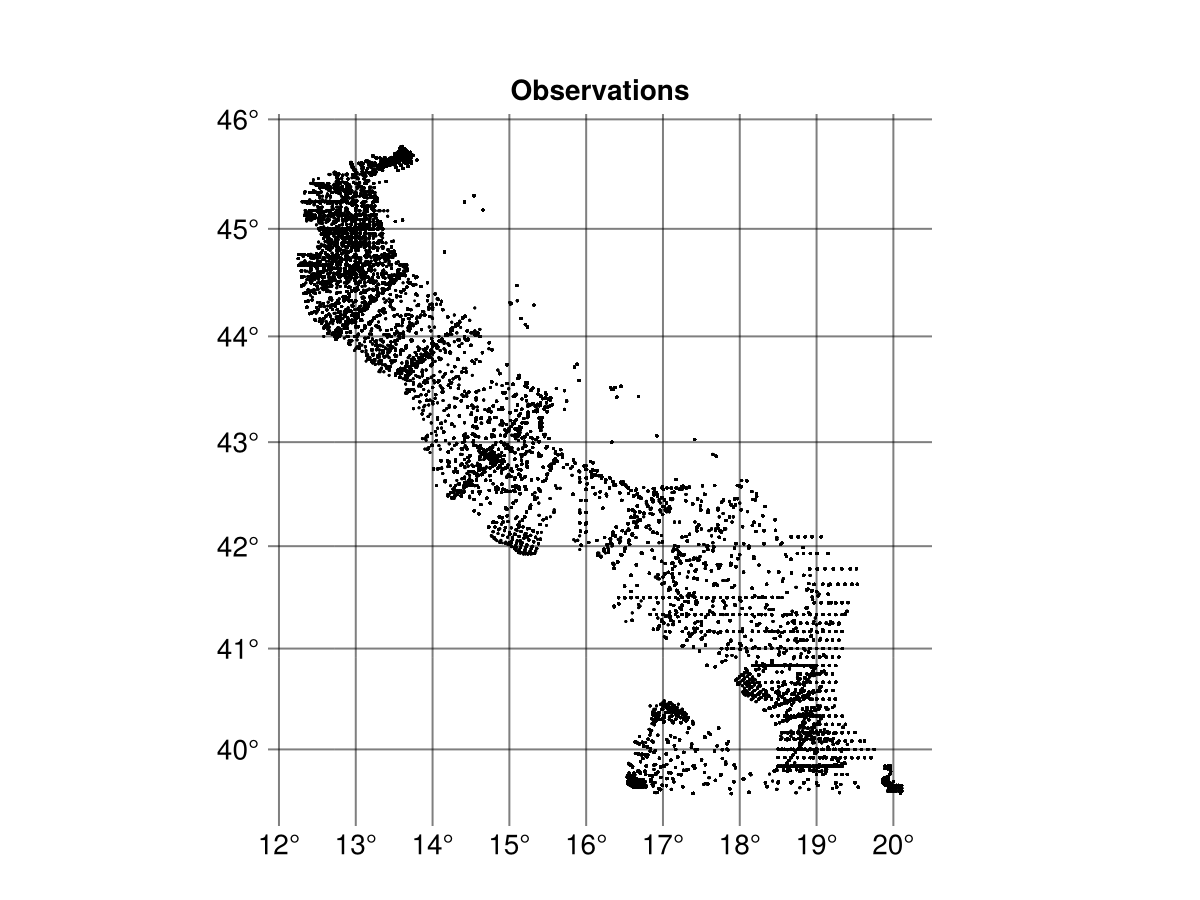

In [5]:
f = Figure()
ax = GeoAxis(f[1,1], dest = "+proj=merc", title="Observations")
scatter!(ax, obslon, obslat; markersize=2, color = :black)
f

Check the extremal values of the observations

In [6]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (12.25016975402832, 20.110000610351562)
              minimum and maximum of obs. dimension 2: (39.556758880615234, 45.755001068115234)
              minimum and maximum of obs. dimension 3: (0.0, 1484.2030029296875)
              minimum and maximum of obs. dimension 4: (DateTime("1911-08-17T09:24:00"), DateTime("2015-02-10T10:43:00"))
                          minimum and maximum of data: (4.070000171661377, 40.880001068115234)


## 2. Extract the bathymetry
It is used to delimit the domain where the interpolation is performed.

### 2.1 Choice of bathymetry
Modify `bathname` according to the resolution required.

In [7]:
bathname = gebco08file
download_check(bathname, gebco08fileURL)

[ Info: File already downloaded


In [8]:
@time bx,by,b = load_bath(bathname,true,lonr,latr);

  1.734981 seconds (5.50 M allocations: 280.294 MiB, 1.53% gc time, 99.76% compilation time)


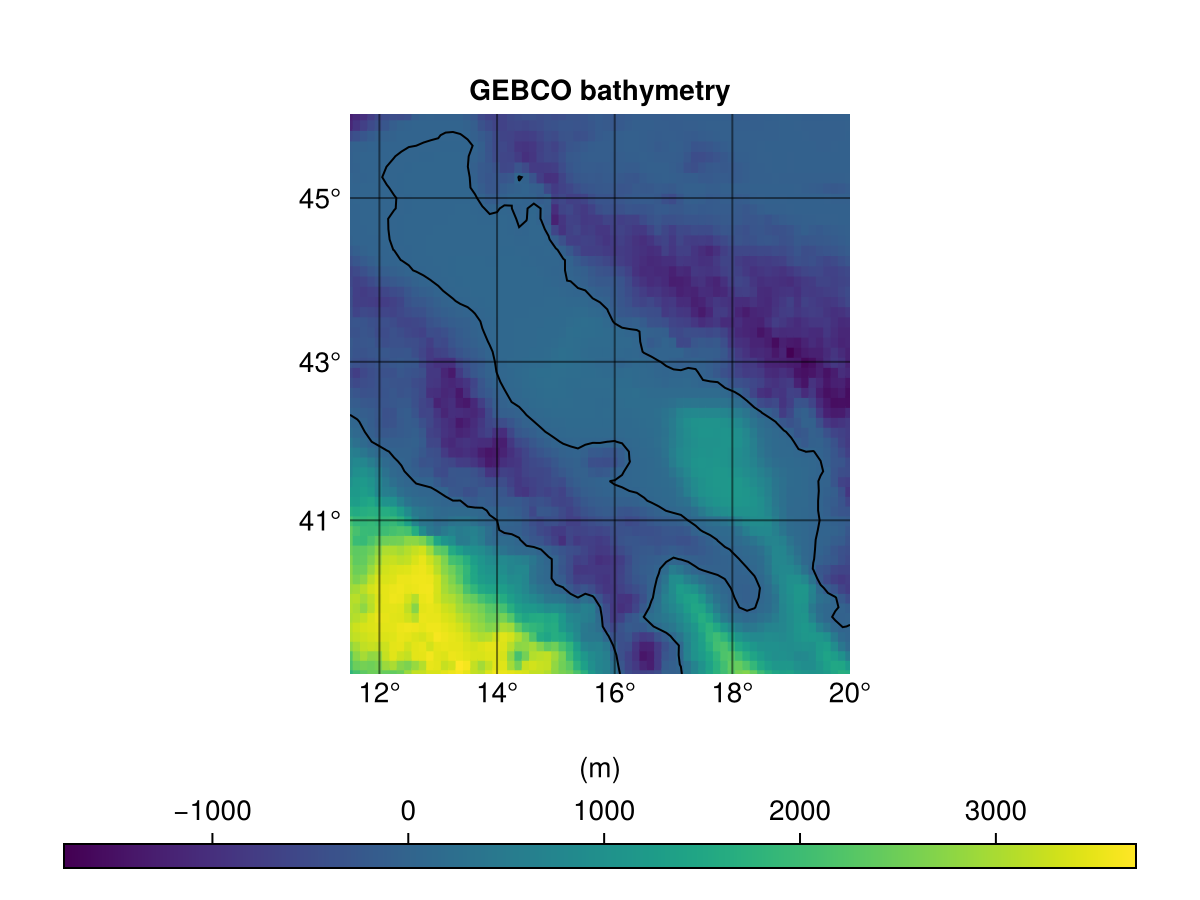

In [9]:
plot_bathy(bx, by, b, xticks=10.:2.:20., yticks=39.:2:48.)

### Create mask
* False for sea        
* True for land

In [10]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)

size(mask) = (69, 57, 20)


(69, 57, 20)

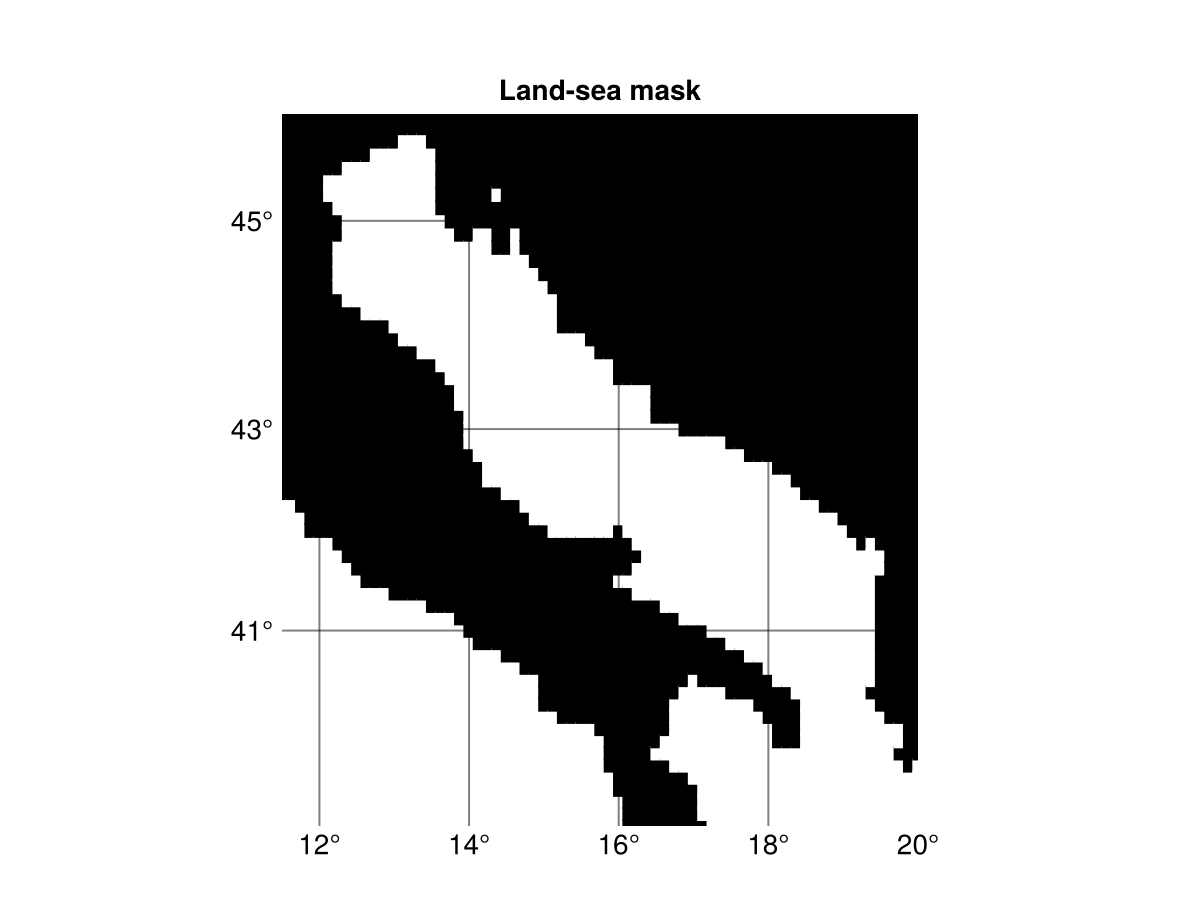

In [11]:
plot_mask(bx, by, mask[:,:,1], xticks=10.:2.:20., yticks=39.:2:48.)

### Edit the mask
As an example we will remove the Tyrrhenian Sea from the domain.

In [12]:
grid_bx = [i for i in bx, j in by];
grid_by = [j for i in bx, j in by];

In [13]:
mask_edit = copy(mask);
sel_mask1 = (grid_by .<= 42.6) .& (grid_bx .<= 14.);
sel_mask2 = (grid_by .<= 41.2) .& (grid_bx .<= 16.2);
mask_edit = mask_edit .* .!sel_mask1 .* .!sel_mask2;
@show size(mask_edit)

size(mask_edit) = (69, 57, 20)


(69, 57, 20)

In [14]:
#sel = (obslon .<  maximum(bx)) .& (obslon .>  minimum(bx)) .& (obslat .<  maximum(by)) .& (obslat .>  minimum(bx))
#obslon=obslon[sel]
#obslat=obslat[sel]
#obsdepth=obsdepth[sel]
#obsval=obsval[sel]

The edited mask now looks like this:

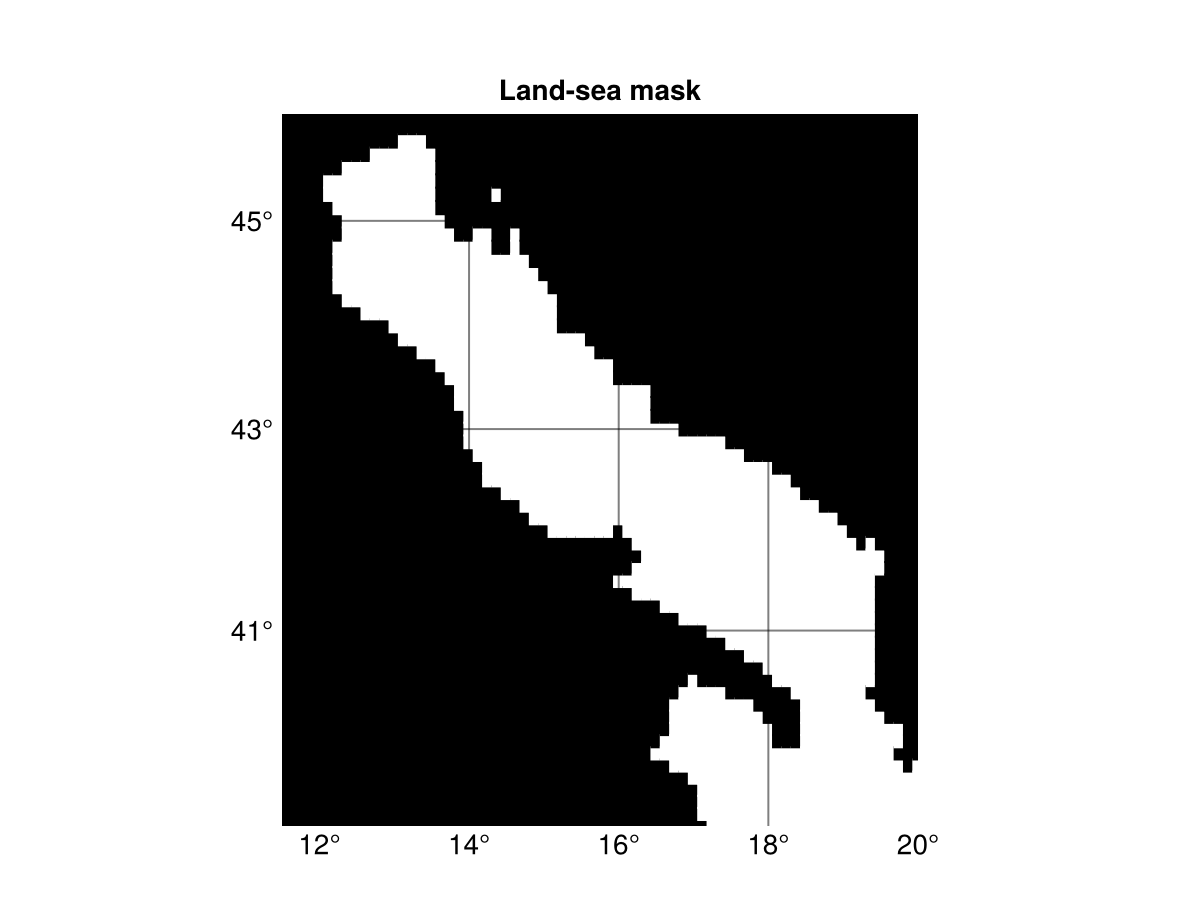

In [15]:
plot_mask(bx, by, mask_edit[:,:,1], xticks=10.:2.:20., yticks=39.:2:48.)

## Define a vertical correlation length function in real space

In [16]:
function Lvert(x,y,z)
    return 5.0 + z/5.0
end

LHOR=1.5
eps2=0.1
iscyclic=falses(3)

3-element BitVector:
 0
 0
 0

## Analysis in Cartesian Coordinates (degrees for simplicity)

In [17]:
xc,yc,zc=ndgrid(lonr,latr,depthr)
pmc = ones(size(xc)) / (xc[2,1,1]-xc[1,1,1]);
pnc = ones(size(xc)) / (yc[1,2,1]-yc[1,1,1]);
poc = ones(size(xc)) / (zc[1,1,2]-zc[1,1,1]);

In [18]:
aspectratio = 1/cos(mean(latr) * pi/180)
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(LHOR,sz)  
leny = lenx./aspectratio
lenz = Lvert.(xc,yc,zc);
@show mean(lenx),mean(leny),mean(lenz)
epsilon2 = eps2;
#epsilon2 = epsilon2 * rdiag;

(mean(lenx), mean(leny), mean(lenz)) = (1.5, 1.105916005215185, 21.43)


In [19]:
obsmean=mean(obsval)

fi,s=DIVAndrun(mask_edit,(pmc,pnc,poc),(xc,yc,zc),(obslon,obslat,obsdepth),obsval.-obsmean,(lenx,leny,lenz),epsilon2);

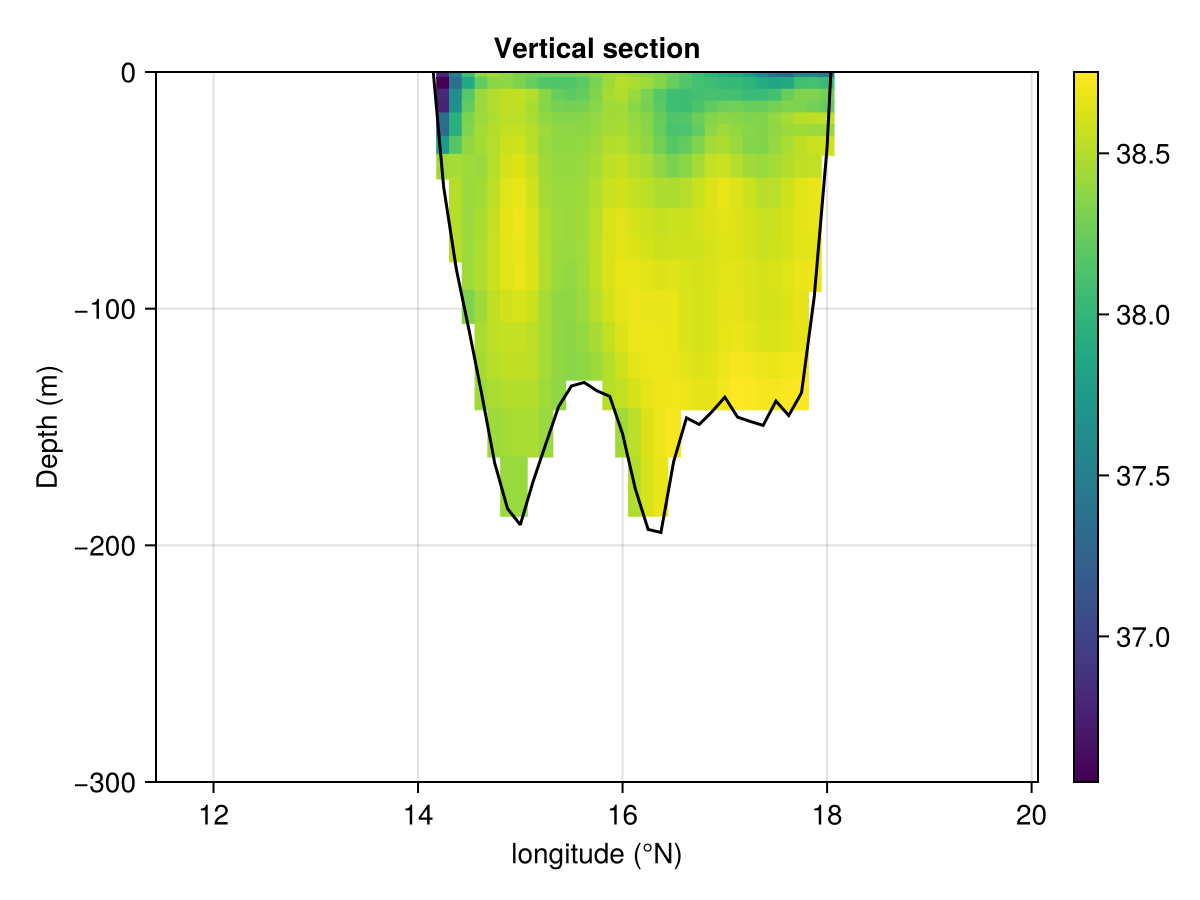

In [20]:
jcut=30

f = Figure()
ax = Axis(f[1,1], title="Vertical section", ylabel = "Depth (m)", xlabel = "longitude (°N)")
hm = heatmap!(ax, xc[:,jcut,1],-zc[1,jcut,:],fi[:,jcut,:].+obsmean)
lines!(ax, bx,-b[:,jcut], color=:black)
Colorbar(f[1, 2], hm)
ylims!(-300, 0.0)
f

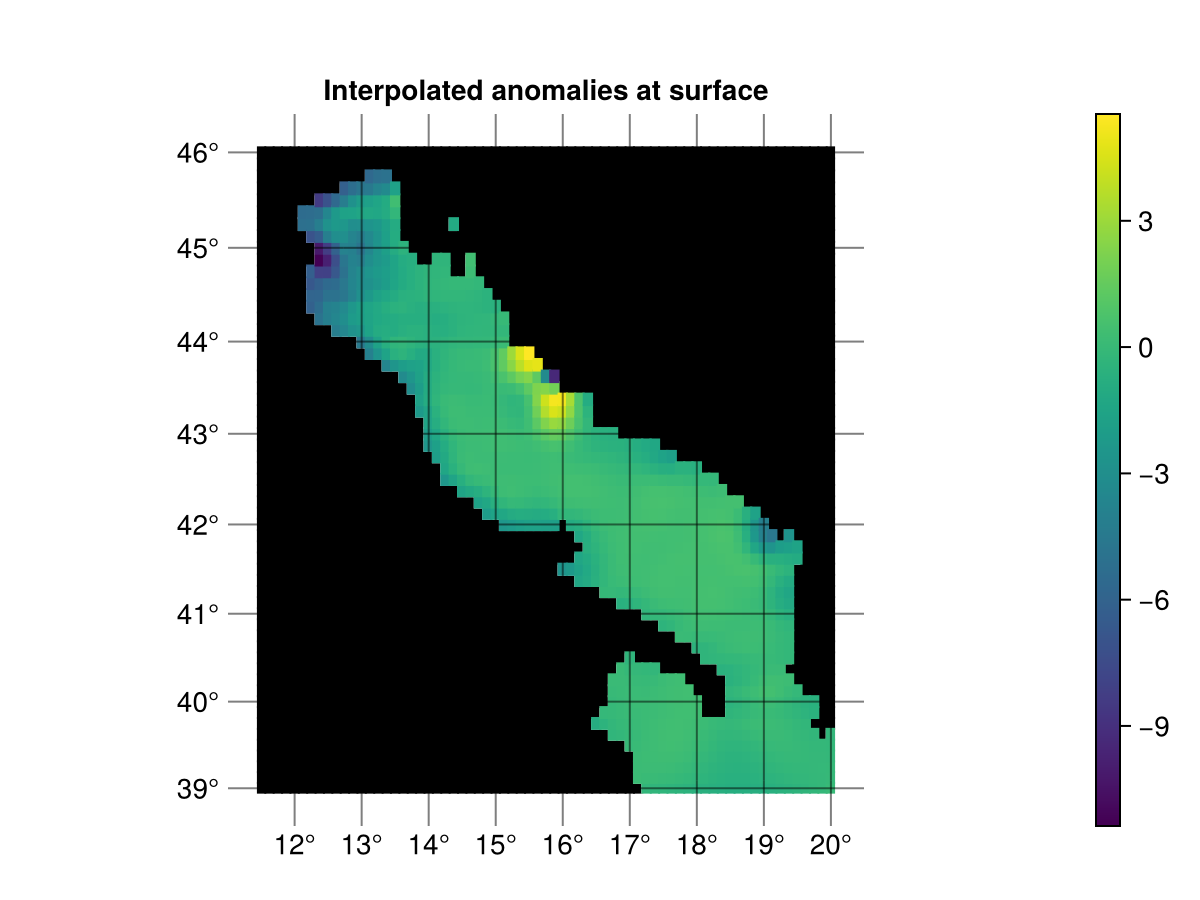

In [21]:
f = Figure()
ax = GeoAxis(f[1,1], dest = "+proj=merc", title="Interpolated anomalies at surface")
heatmap!(ax, lonr, latr, mask_edit[:,:,1], colormap=Reverse(:binary))
hm = heatmap!(ax, lonr, latr,fi[:,:,1])
Colorbar(f[1, 2], hm)
f

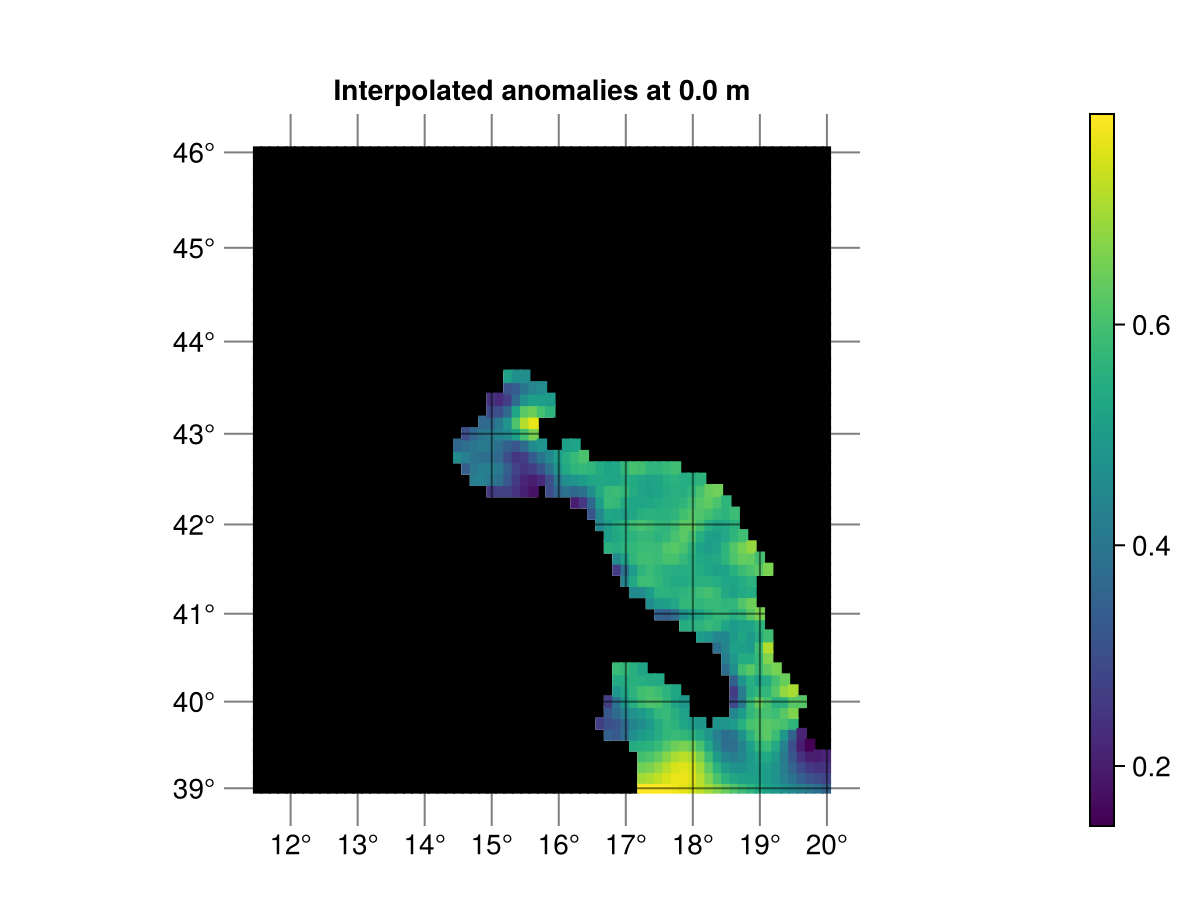

In [22]:
kcut=15
f = Figure()
ax = GeoAxis(f[1,1], dest = "+proj=merc", title="Interpolated anomalies at $(zc[kcut]) m")
heatmap!(ax, lonr, latr, mask_edit[:,:,kcut], colormap=Reverse(:binary))
hm = heatmap!(ax, lonr, latr,fi[:,:,kcut])
Colorbar(f[1, 2], hm)
f

# 4.  Coordinate change

In [23]:
bfun=linear_interpolation((bx,by),b;extrapolation_bc=0.0)

function ztosigma(x,y,z)
    return z/max(2.0,bfun(x,y))
end
function sigmatoz(x,y,sigma)
    return sigma*max(2.0,bfun(x,y))
end
# Needed to get fracional indexes and horizontal plots

sigmatoz (generic function with 1 method)

<div class="alert alert-block alert-info">
ℹ️ For more general cases it is easy to make the z(sigma) function more general, but then the inverse will need some
search of zeros. 
</div>

### Vertical position in sigma space

In [24]:
obssigma=ztosigma.(obslon,obslat,obsdepth);

In [25]:
xs,ys,sigma=ndgrid(lonr,latr,range(0;stop=1,length=25))
# vertical position in real space
zs=sigmatoz.(xs,ys,sigma)
pms = ones(size(xs)) / (xs[2,1,1]-xs[1,1,1]);
pns = ones(size(xs)) / (ys[1,2,1]-ys[1,1,1]);
pos = ones(size(xs)) / (sigma[1,1,2]-sigma[1,1,1]);
sz=size(xs)
masks=trues(size(xs))
masks[:,:,:].=mask_edit[:,:,1]

lenx = fill(LHOR,sz)  
leny = lenx./aspectratio
lenz = Lvert.(xs,ys,zs);    

# Since you work in sigma space:
lenz=lenz./max.(2.0,bfun.(xs,ys))
    
epsilon2 = eps2;
#epsilon2 = epsilon2 * rdiag;
obsmean=mean(obsval)

fi,s=DIVAndrun(masks,(pms,pns,pos),(xs,ys,sigma),(obslon,obslat,obssigma),obsval.-obsmean,(lenx,leny,lenz),epsilon2);

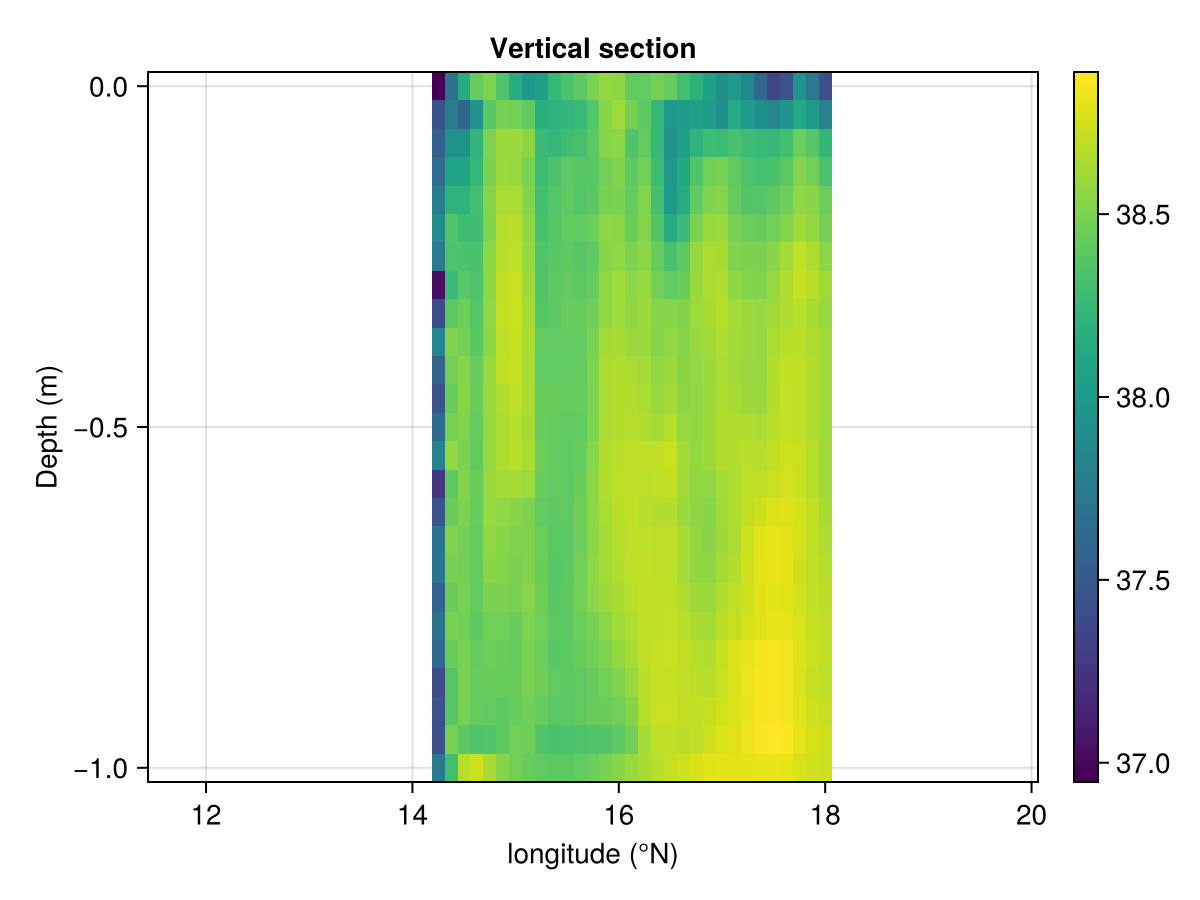

In [26]:
jcut = 30
f = Figure()
ax = Axis(f[1,1], title="Vertical section", ylabel = "Depth (m)", xlabel = "longitude (°N)")
hm = heatmap!(ax, xs[:,jcut,1],-sigma[1,jcut,:],fi[:,jcut,:].+obsmean)
Colorbar(f[1, 2], hm)
f

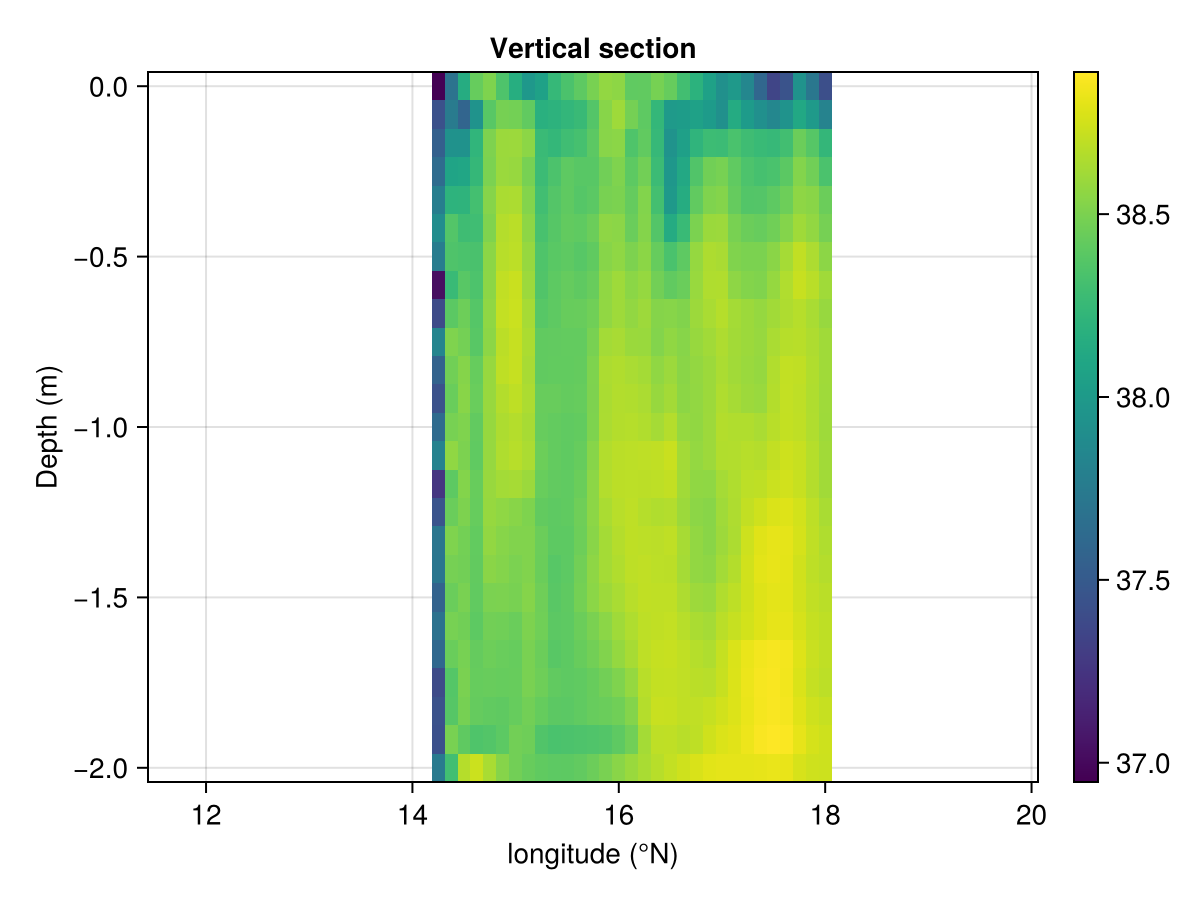

In [27]:
jcut = 30
f = Figure()
ax = Axis(f[1,1], title="Vertical section", ylabel = "Depth (m)", xlabel = "longitude (°N)")
hm = heatmap!(ax, xs[:,jcut,1],-zs[1,jcut,:],fi[:,jcut,:].+obsmean)
Colorbar(f[1, 2], hm)
f

## Now exploiting directly non-uniform grids by creating the pmn etc
We already have the z positions of the sigma layers we want to work with from above.       
So now just recalculate the metrics:

In [28]:
pozc=deepcopy(pos)
for i = 1:sz[3]
        i0 = max(i - 1, 1)
        i1 = min(i + 1, sz[3])
        pozc[:,:,i].=(i1-i0)./(zs[:,:,i1].-zs[:,:,i0])
end
# Or simpler divide sigma pos  b: No the former is more general in case you have different stretching depending on depth
# pocz=pos./max.(2.0,bfun.(xs,ys));

### Get fractional indexes by working in sigma space:

In [29]:
Igrid = localize_separable_grid((obslon,obslat,obssigma), masks, (xs,ys,sigma), iscyclic)

3×1430741 Matrix{Float64}:
 57.928  57.928    57.928    57.928    …  61.8532   61.8532   61.8532
 12.864  12.864    12.864    12.864        9.81424   9.81424   9.81424
  1.0     1.63147   2.26295   2.89442      1.04422   1.04422   1.04422

In [30]:
masks[:,:,:].=mask_edit[:,:,1]


lenx = fill(LHOR,sz)  
leny = lenx./aspectratio
lenz = Lvert.(xs,ys,zs);

epsilon2 = eps2;
#epsilon2 = epsilon2 * rdiag;
obsmean=mean(obsval)

fi,s=DIVAndrun(masks,(pms,pns,pozc),(xs,ys,zs),(obslon,obslat,obsdepth),obsval.-obsmean,(lenx,leny,lenz),epsilon2;fracindex =Igrid);

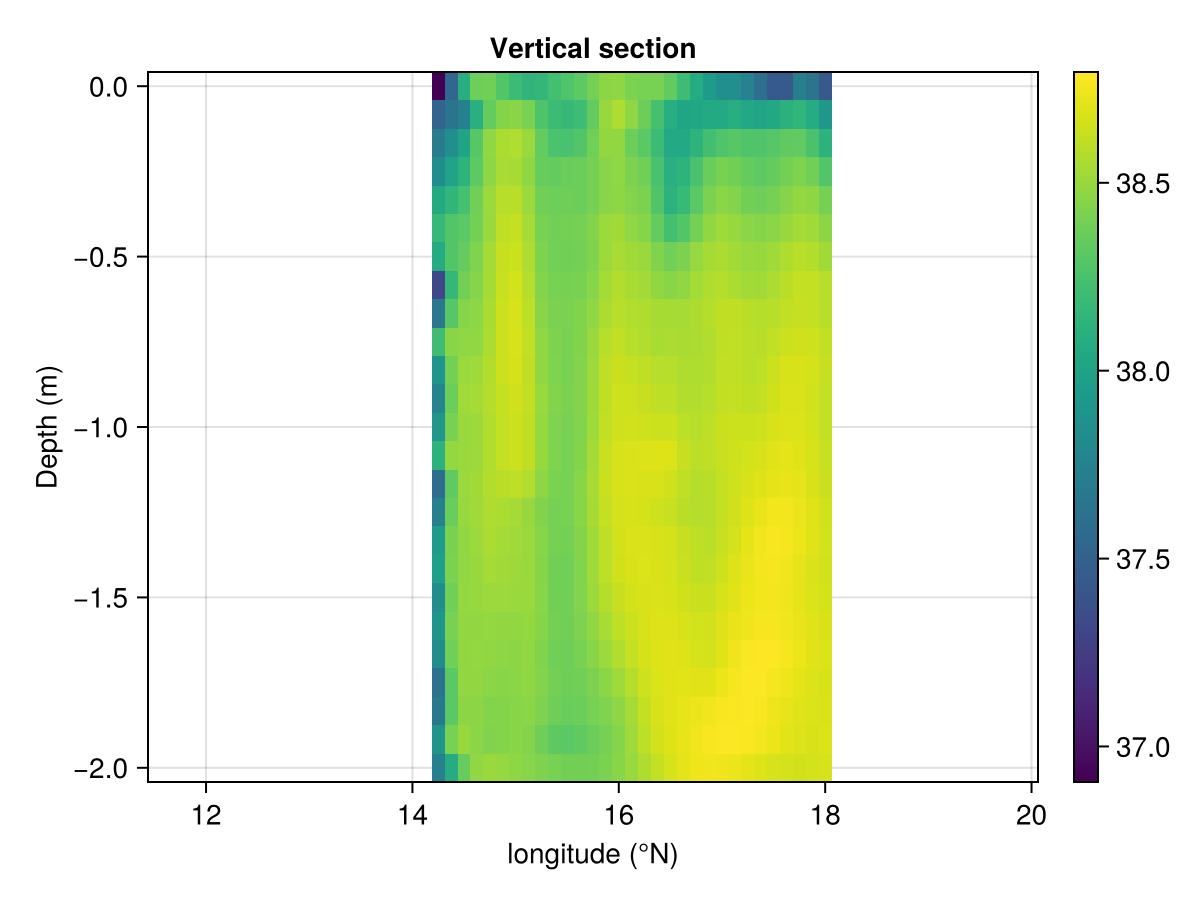

In [31]:
jcut = 30
f = Figure()
ax = Axis(f[1,1], title="Vertical section", ylabel = "Depth (m)", xlabel = "longitude (°N)")
hm = heatmap!(ax, xs[:,jcut,1],-zs[1,jcut,:],fi[:,jcut,:].+obsmean)
Colorbar(f[1, 2], hm)
f

## How to make a horizontal plot



In [32]:
kcut = 15
zcut=zc[1,1,kcut]
# Create fake data
sigmaonzlevel=ztosigma.(xs[:,:,1],ys[:,:,1],zcut.+ 0.0 .*ys[:,:,1])

Igridcut=localize_separable_grid((xs[:,:,1],ys[:,:,1],sigmaonzlevel), masks, (xs,ys,sigma), )
Htoz, out, outbbox = sparse_interp(masks, Igridcut, iscyclic)

(sparse([10, 10, 11, 11, 12, 12, 13, 13, 14, 14  …  2444, 2444, 2382, 2382, 2444, 2444, 2584, 2584, 2584, 2584], [10, 11, 11, 12, 12, 13, 13, 14, 14, 15  …  96836, 96837, 96843, 96844, 96905, 96906, 96976, 96977, 97045, 97046], [0.07064581720119789, 0.0, 0.07662300714237547, 0.0, 0.11550606829238541, 0.0, 0.11515640301647667, 0.0, 0.1407236368461524, 0.0  …  0.8696029693408533, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5430600131042596, 0.0, 0.0, 0.0], 3933, 98325), Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
Htoz=Htoz*sparse_pack(masks)';

In [34]:
zlevelsol=Htoz*statevector_pack(s.sv, (fi,));

In [35]:
soltoplot=reshape(zlevelsol,size(xs)[1:2])
# Need to apply mask because that is not included in the interpolation
soltoplot[zcut.>b].=NaN
soltoplot[mask_edit[:,:,1].==0].=NaN;

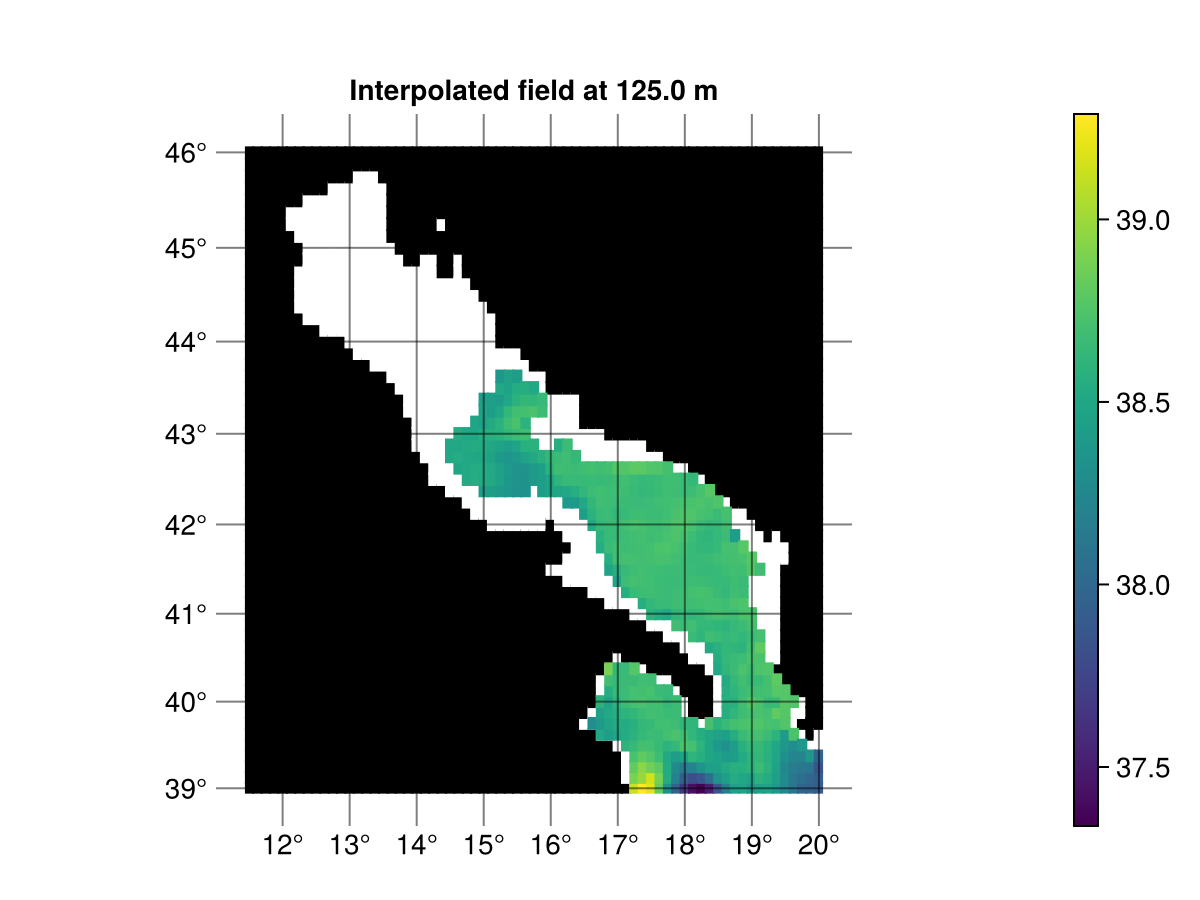

In [36]:
f = Figure()
ax = GeoAxis(f[1,1], dest = "+proj=merc", title="Interpolated field at $(depthr[kcut]) m")
heatmap!(ax, lonr, latr, mask_edit[:,:,1], colormap=Reverse(:binary))
hm = heatmap!(ax, lonr, latr, soltoplot .+ obsmean)
Colorbar(f[1, 2], hm)
f

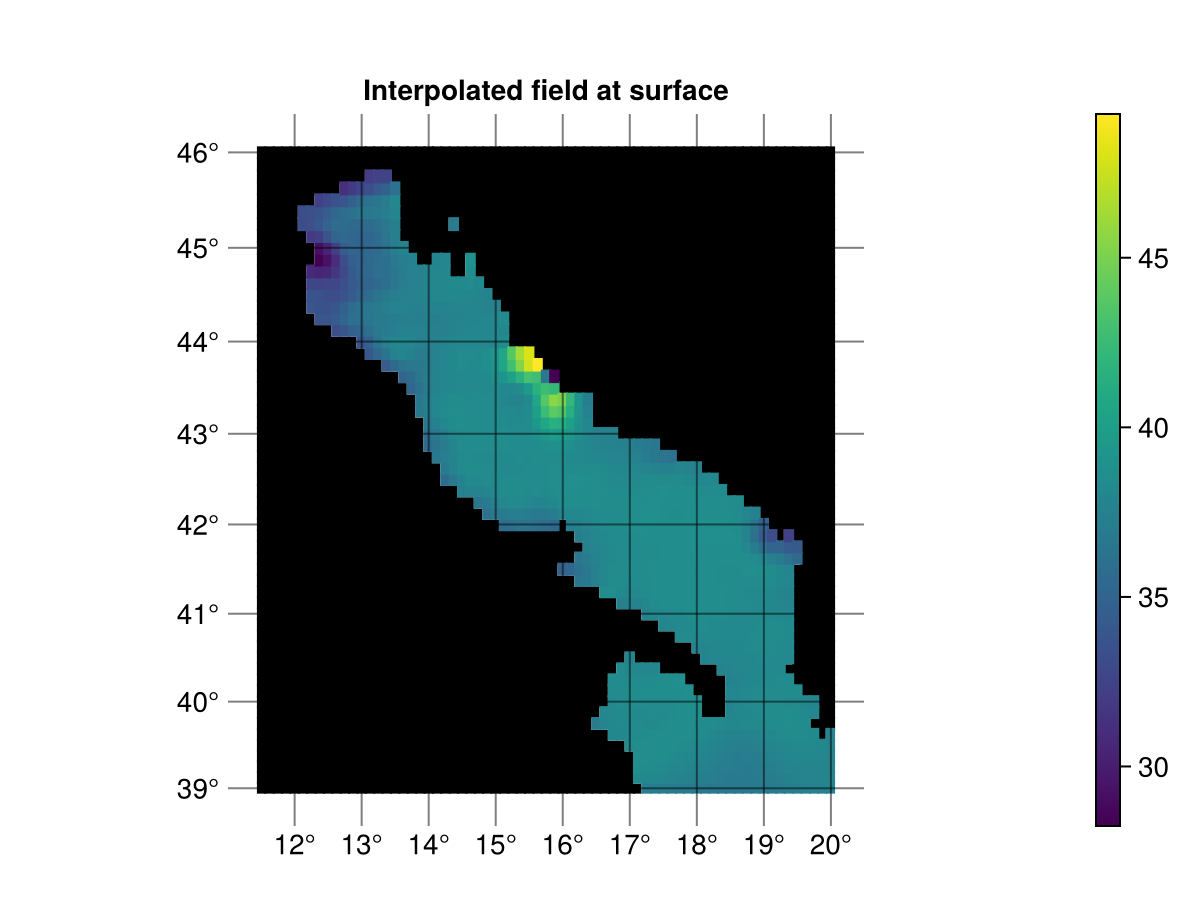

In [37]:
f = Figure()
ax = GeoAxis(f[1,1], dest = "+proj=merc", title="Interpolated field at surface")
heatmap!(ax, lonr, latr, mask_edit[:,:,1], colormap=Reverse(:binary))
hm = heatmap!(ax, lonr, latr, fi[:,:,1] .+ obsmean)
Colorbar(f[1, 2], hm)
f